In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, \
BatchNormalization, Cropping2D, Lambda, Activation, Dropout
from keras.optimizers import Adam, Nadam

/home/freddy/apps/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
driving_log = pd.read_csv('data/driving_log.csv', names=['center','left','right','angle','throttle','brake','speed'])

In [3]:
center_left_right_angle = driving_log[['center', 'left', 'right', 'angle']]

In [4]:
def processFilename(filename):
  filename = filename.split('/')
  filename = 'data/{}/{}'.format(filename[-2], filename[-1])
  return filename
# enddef

In [5]:
def read_images(driving_log):
  images = []
  angles = []
  for row in driving_log.itertuples():
    angle = row.angle
    
    # for center image
    image = plt.imread( processFilename(row.center) )
    image = cv2.resize(image, (160, 80))
    images.append(image)
    angles.append(angle)
    
    # for left image
    image = plt.imread( processFilename(row.left) )
    image = cv2.resize(image, (160, 80))
    images.append(image)
    angles.append(angle + 0.2)
    
    # for right image
    image = plt.imread( processFilename(row.right) )
    image = cv2.resize(image, (160, 80))
    images.append(image)
    angles.append(angle - 0.2)
    
    # end if
  # end for
  return np.array(images), np.array(angles)
# end def

In [6]:
images, angles = read_images(center_left_right_angle)

In [7]:
images.shape

(12603, 80, 160, 3)

In [8]:
def memory_usage(data):
  mem_use = 4
  for i in data.shape:
    mem_use *= i
  return mem_use

In [9]:
print('memory use = {:.3g} gb'.format( memory_usage(images) / np.power(2,30)) )

memory use = 1.8 gb


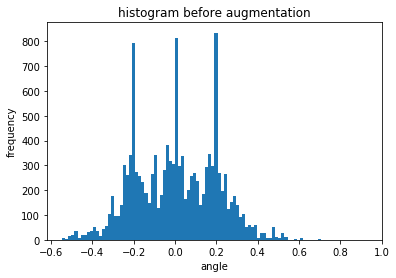

In [10]:
plt.hist(angles, bins=100)
plt.xlabel('angle')
plt.ylabel('frequency')
plt.title('histogram before augmentation')
plt.show()

In [11]:
# augment the data set
augmented_images = []
augmented_angles = []
for image, angle in zip(images, angles):
  augmented_images.append(image)
  augmented_angles.append(angle)
  
  augmented_images.append(cv2.flip(image, 1))
  augmented_angles.append(-angle)
# end for

augmented_images = np.array(augmented_images)
augmented_angles = np.array(augmented_angles)

In [12]:
print('memory use = {:.3g} gb'.format( memory_usage(augmented_images) / np.power(2,30)) )

memory use = 3.61 gb


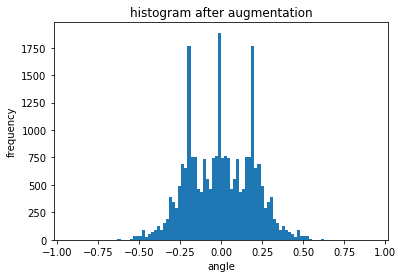

In [13]:
plt.hist(augmented_angles, bins=100)
plt.xlabel('angle')
plt.ylabel('frequency')
plt.title('histogram after augmentation')
plt.show()

# as you can see, it is now normally distributed

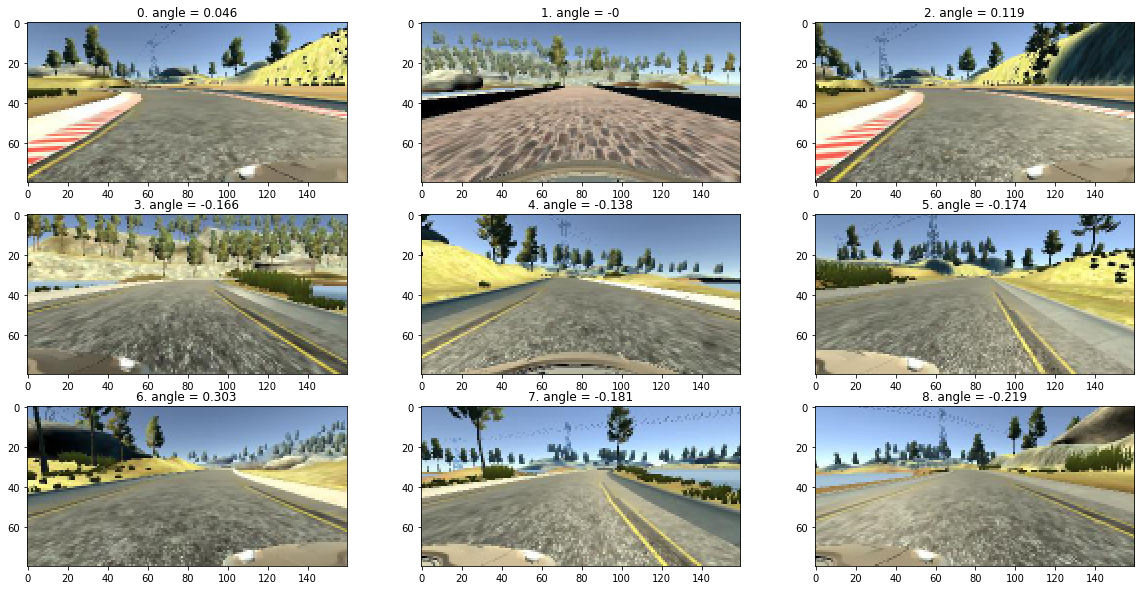

In [14]:
random_images = np.random.randint(0,augmented_images.shape[0],size=(3*3,))
# plot images in original RGB mode
plt.figure(figsize=(20,10))
for idx, i in enumerate(random_images):
  plt.subplot(3, 3, idx+1)
  plt.imshow(augmented_images[i,:,:,:])
  plt.title('{}. angle = {:.3g}'.format(idx, augmented_angles[i]))

In [15]:
augmented_images.shape

(25206, 80, 160, 3)

In [16]:
def nvidia():
  model = Sequential()
  model.add(Cropping2D(cropping=((35,12), (0,0)), input_shape=(80,160,3)))
  model.add(BatchNormalization())
  
  model.add(Conv2D(24, 5, strides=1, padding='valid'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(36, 5, strides=1, padding='valid'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(48, 5, strides=1, padding='valid'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(64, 3, padding='valid'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(64, 3, padding='valid'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Flatten())

  model.add(Dense(100))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Dense(50))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Dense(10))  
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Dense(1))
  
  return model

In [17]:
model = nvidia()
optimizer = Adam(lr=1e-3)
model.compile(loss='mse', optimizer=optimizer)

In [18]:
np.random.seed(1)

In [19]:
model.fit(
  x=augmented_images, y=augmented_angles, 
  batch_size=500, epochs=20, verbose=1, validation_split=0.2, shuffle=True
)

Train on 20164 samples, validate on 5042 samples
Epoch 1/20
20164/20164 [==============================] - 24s 1ms/step - loss: 0.1783 - val_loss: 0.1304
Epoch 2/20
20164/20164 [==============================] - 21s 1ms/step - loss: 0.0190 - val_loss: 0.0277
Epoch 3/20
20164/20164 [==============================] - 21s 1ms/step - loss: 0.0142 - val_loss: 0.0235
Epoch 4/20
20164/20164 [==============================] - 21s 1ms/step - loss: 0.0106 - val_loss: 0.0221
Epoch 5/20
20164/20164 [==============================] - 21s 1ms/step - loss: 0.0089 - val_loss: 0.0210
Epoch 6/20
20164/20164 [==============================] - 21s 1ms/step - loss: 0.0071 - val_loss: 0.0206
Epoch 7/20
20164/20164 [==============================] - 21s 1ms/step - loss: 0.0062 - val_loss: 0.0202
Epoch 8/20
20164/20164 [==============================] - 21s 1ms/step - loss: 0.0057 - val_loss: 0.0209
Epoch 9/20
20164/20164 [==============================] - 21s 1ms/step - loss: 0.0049 - val_loss: 0.0200
Epoch 

In [20]:
model.save('params/model.h5')
model.save_weights('params/model_weights.h5')